In [1]:
import time
# Start the script run timer
script_start_time = time.time()


import argparse
import os
# import logging as log
import pandas as pd 
import geopandas as gpd
# import requests
# from typing import Dict, List,Union
from requests import get
from pyrosm import OSM, get_data
# from pyrosm.data import sources
from pyrosm import OSM
# from pyrosm.config import Conf

In [2]:
#----------------------- for notebook run/Debugging------------------------------------
config_file_path='config/config_linking_tool.yml'

## ii. import local packages

In [3]:
from linkingtool import linking_utility as utils
from linkingtool import linking_vis as vis
from linkingtool import linking_solar as solar
from linkingtool import linking_wind as wind
from linkingtool import linking_data as dataprep

In [4]:
"""
__________________________________________________________________________________
                                [ The Main Function Starts below ]
__________________________________________________________________________________
"""
# def main(config_file_path):
## iii. Setup the LOGGING directory and associated day/time

log_path=f'workflow/log/data_preparation_log.txt'
log=utils.create_log(log_path)

## Load Config and Set some sub-config dict.

In [5]:
# config_file_path='config/config_master.yml' # hush if not notebook
config:dict[dict]=utils.load_config(config_file_path)

base_path = os.getcwd()  # Or specify a different base path if needed

# Recreate the directory structure
utils.create_directories(base_path, config['required_directories'])
log.info("All directories have been created successfully.")


linking_data:dict[dict]=config['processed_data']['linking']
disaggregation_config:dict[dict]=config['capacity_disaggregation']
vis_dirc=config['visualization']['linking']

# Set Current Region and Processed Data Directory from User Config
country:str = config['country']
current_region:dict[dict]=config['regional_info']['region_1']
_CRC_ = current_region['code'] #current region short-code
log.info(f"Processing the datafiles for {current_region['name']}[{_CRC_}]")

2024-09-18 11:39:42 - INFO - All directories have been created successfully.
2024-09-18 11:39:42 - INFO - Processing the datafiles for British Columbia[BC]


 >> !! 'data' already exists
 >> !! 'clews_data' already exists
 >> !! 'downloaded_data' already exists
 >> !! 'CODERS' already exists
 >> !! 'network' already exists
 >> !! 'supply' already exists
 >> !! 'demand' already exists
 >> !! 'reserve' already exists
 >> !! 'fuel_price' already exists
 >> !! 'emission' already exists
 >> !! 'macro_indicators' already exists
 >> !! 'cutout' already exists
 >> !! 'GADM' already exists
 >> !! 'GAEZ' already exists
 >> !! 'GWA' already exists
 >> !! 'Gov' already exists
 >> !! 'Conservation_Lands' already exists
 >> !! 'Population' already exists
 >> !! 'CEEI' already exists
 >> !! 'load' already exists
'load' has no subdirectories
 >> !! 'OEDB' already exists
 >> !! 'OSM' already exists
 >> !! 'aeroway' already exists
 >> !! 'regions' already exists
'regions' has no subdirectories
 >> !! 'wind' already exists
'wind' has no subdirectories
 >> !! 'NREL' already exists
 >> !! 'ATB' already exists
 >> !! 'processed_data' already exists
 >> !! 'netwo

## i. Create Required Directories

In [6]:
# Get the required directories from the configuration
    
data_download_root='data/downloaded_data'

## ii. Units' Dictionary

In [7]:
# Create Units Dictionary in Excel
units_file_path=config['units_dictionary']
dataprep.create_units_dictionary(units_file_path)

2024-09-18 11:39:42 - INFO - Units Dictionary Created and saved to 'data/Data_Units.xlsx'


## iii. GADM data

In [8]:
#  Prepare Regional Boundaries (GADM)
GADM_file_save_to:str = os.path.join(config['GADM']['root'],config['GADM']['datafile'])
admin_level=2
plot_save_to:str=os.path.join("vis/misc",f"{_CRC_}_gadm_regions.png")

utils.check_LocalCopy_and_run_function(
    GADM_file_save_to,
    lambda:dataprep.prepare_GADM_data(
        country,
        current_region,
        GADM_file_save_to,
        plot_save_to,
        admin_level),
    force_update=True)

#load datafile as GeoDataFrame for further usage in plotting
province_gadm_regions_gdf:gpd.GeoDataFrame=gpd.read_file(GADM_file_save_to)

#impute population data to GADM gdf
config_population:dict=config['Gov']['Population']
population_csv_data_path=os.path.join(config_population['root'],config_population['datafile'])

log.info(f"Updating population data")
province_gadm_regions_gdf= utils.update_population_data(config_population,province_gadm_regions_gdf,population_csv_data_path)

province_gadm_regions_gdf.to_file(GADM_file_save_to,driver='GeoJSON') #save the local file as geojson
log.info("population data imputed to GADM datafile")

2024-09-18 11:39:44 - INFO - GADM (level=2) BC Boundary loaded. No. of Regions : 28
2024-09-18 11:39:44 - INFO - Directory 'vis/misc/BC_gadm_regions.png' found locally.
2024-09-18 11:39:44 - INFO - Forcefully ran '<lambda>' on 'data/downloaded_data/GADM/BC_gadm_regions.geojson'.
2024-09-18 11:39:44 - INFO - Updating population data
2024-09-18 11:39:44 - INFO - population data imputed to GADM datafile


## iv. CODERS data
    log.info(f"Processing CODERS data...")

In [9]:
CODERS_data:dict=config['CODERS']
CODERS_url:str=CODERS_data['url_1']
api_key_elias:str='?key='+CODERS_data['api_key']['Elias']

log.warning(f"If you are using limited time access key from the developer. Please contact {CODERS_data['api_key']['contact_for_request']} to request your own access keys.")
print(f">> !! \n Please Check API documentation for more details >> {CODERS_data['api_documentation']}\n")

# >>>>>>>>>>> Currently sourcing from PYPSA data prep scripts
# generators_df:pd.DataFrame=dataprep.create_dataframe_from_CODERS('generators',CODERS_url,api_key_elias)

provincial_bus_csv_file_path=disaggregation_config['transmission']['buses']
provincial_lines_csv_file_path=disaggregation_config['transmission']['lines'] #required for buses datafile preparation

if os.path.exists(provincial_bus_csv_file_path):
    log.info(f"Lines data for {current_region['code']} found locally at : {provincial_lines_csv_file_path}")
    pass
else:
    tx_lines_df:pd.DataFrame=dataprep.create_dataframe_from_CODERS('transmission_lines',CODERS_url,api_key_elias)
    provincial_mask=tx_lines_df['province']==_CRC_
    province_tx_lines:pd.DataFrame=tx_lines_df[provincial_mask]

    province_tx_lines.to_csv(provincial_lines_csv_file_path)
    log.info(f"Lines data data created for {_CRC_} and saved to {provincial_lines_csv_file_path}")

if os.path.exists(provincial_bus_csv_file_path):
    log.info(f"BUS data for {current_region['code']} found locally at : {provincial_bus_csv_file_path}")
    pass
else:
    substations_df=dataprep.create_dataframe_from_CODERS('substations',CODERS_url,api_key_elias)
    provincial_mask=substations_df['province']==_CRC_
    province_SS:pd.DataFrame=substations_df[provincial_mask]

    utils.check_LocalCopy_and_run_function(provincial_bus_csv_file_path,lambda:dataprep.create_bus_df(province_tx_lines, province_SS,provincial_bus_csv_file_path),force_update=True)
    log.info(f"BUS data created for {current_region['code']} and saved to {provincial_bus_csv_file_path}")

provincial_bus_df:pd.DataFrame=pd.read_csv(provincial_bus_csv_file_path)

nodes_datafile_name=linking_data['transmission']['nodes_datafile']
nodes_datafile_save_to=os.path.join('data/processed_data',nodes_datafile_name)
plot_save_to=os.path.join("vis/misc",nodes_datafile_name.replace('.pkl','.png'))
log.info(f"Transmission nodes' plot saved to {plot_save_to}")

provincial_bus_gdf=dataprep.create_grid_nodes(provincial_bus_df,province_gadm_regions_gdf,nodes_datafile_save_to,plot_save_to)

2024-09-18 11:39:44 - WARNING - If you are using limited time access key from the developer. Please contact mailto:modellingteam.sesit@uvic.ca to request your own access keys.
2024-09-18 11:39:44 - INFO - Lines data for BC found locally at : data/processed_data/lines_BC.csv
2024-09-18 11:39:44 - INFO - BUS data for BC found locally at : data/processed_data/buses_BC.csv
2024-09-18 11:39:44 - INFO - Transmission nodes' plot saved to vis/misc/BC_Transmission.png


>> !! 
 Please Check API documentation for more details >> https://sesit.dev/api/docs



2024-09-18 11:39:45 - INFO - Plot for Grid Nodes Generated and saved as vis/misc/BC_Transmission.png


## v. OEDB Turbine Config

In [10]:
OEDB_config=disaggregation_config['wind']['turbines']['OEDB']
id1=OEDB_config['model_1']['ID']
id2=OEDB_config['model_2']['ID']
ids_to_search = [id1, id2]

OEDB_source=OEDB_config['source']
OEDB_data = get(OEDB_source)
OEDB_turbines_dict=OEDB_data.json()

for turbine_id in ids_to_search:
    turbine_data = dataprep.get_OEDB_dict(OEDB_turbines_dict, 'id', turbine_id)

if turbine_data:
    dataprep.format_and_save_turbine_config(turbine_data, os.path.join(data_download_root,"OEDB"))
else:
    log.info(f"No data found for turbine ID {turbine_id}")

2024-09-18 11:39:47 - INFO - Formatted data saved to 'data/downloaded_data/OEDB/3.2M114_NES.yaml'


## vi. Cutout (weather data)

### a. Bounding Box with MBR from GADM

2024-09-18 11:39:47 - INFO - Calculating the Minimum Bounding Region (MBR) for British Columbia
2024-09-18 11:39:47 - INFO - Geospatial Bounding Box Created for BC Province
2024-09-18 11:39:47 - INFO - Minimum Bounding Rectangle (MBR) created and visuals saved to data/downloaded_data/cutout/BC_MBR.geojson


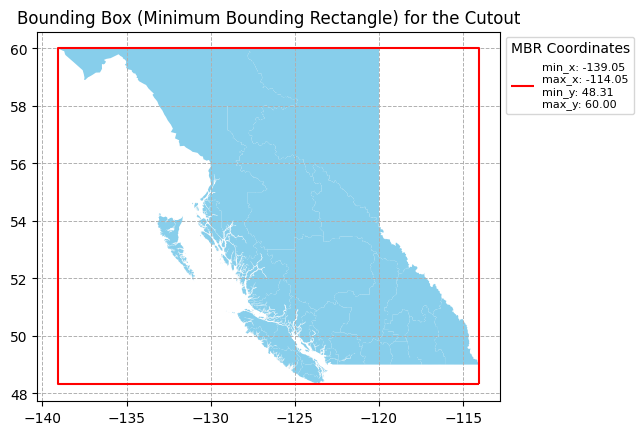

In [11]:
# Bounding Box (Minimum Bounding Rectangle) from GADM boundary
bounding_box_save_to:str=os.path.join(config['cutout']['root'],f"{_CRC_}_MBR.geojson")
bounding_box:dict=dataprep.plot_n_save_bounding_box(province_gadm_regions_gdf,current_region,bounding_box_save_to)
log.info(f"Minimum Bounding Rectangle (MBR) created and visuals saved to {bounding_box_save_to}")

### Prepare ERA5 Cutout

In [12]:
cutout_config=config['cutout']

### a. Bounding Box with MBR from GADM

2024-09-18 11:39:47 - INFO - Calculating the Minimum Bounding Region (MBR) for British Columbia


2024-09-18 11:39:47 - INFO - Geospatial Bounding Box Created for BC Province
2024-09-18 11:39:47 - INFO - Minimum Bounding Rectangle (MBR) created and visuals saved to data/downloaded_data/cutout/BC_MBR.geojson


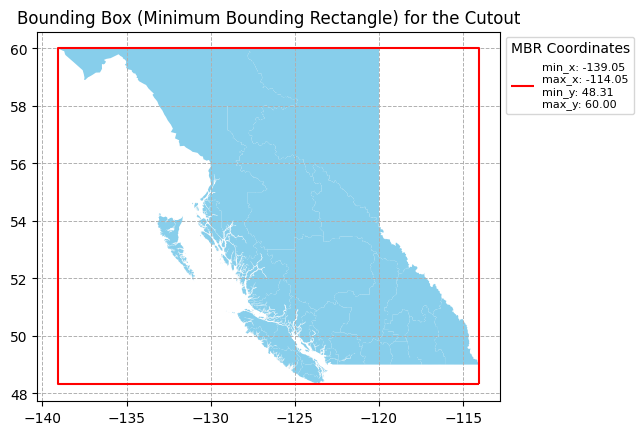

In [13]:
# Bounding Box (Minimum Bounding Rectangle) from GADM boundary
bounding_box_save_to:str=os.path.join(config['cutout']['root'],f"{_CRC_}_MBR.geojson")
bounding_box:gpd.GeoDataFrame=dataprep.plot_n_save_bounding_box(province_gadm_regions_gdf,current_region,bounding_box_save_to)
log.info(f"Minimum Bounding Rectangle (MBR) created and visuals saved to {bounding_box_save_to}")

* dataset timeindex issue has not been resolved by atlite [https://github.com/PyPSA/atlite/issues/379#issuecomment-2359214332]

In [51]:
# cutout_func=create_era5_cutout(_CRC_,bounding_box,cutout_config)  

## vii. GAEZ data

In [ ]:
log.info(f"Preparing GAEZ raster files")
dataprep.prepare_GAEZ_raster_files(config,province_gadm_regions_gdf)

## viii. Gov. data

* CPCAD data

In [52]:
log.info(f"Preparing Conservation and Protected Lands Data")
# Conservation and Protected Lands Data
# source_URL=r"https://data-donnees.az.ec.gc.ca/api/file?path=%2Fspecies%2Fprotectrestore%2Fcanadian-protected-conserved-areas-database%2FDatabases%2FProtectedConservedArea_2022.gdb.zip"
gov_conservation_lands:dict=config['Gov']['conservation_lands']
source_URL:str=gov_conservation_lands['source_url']
gdb_file_name:str = gov_conservation_lands['geodatabase_file']
data_root:str=gov_conservation_lands['data_root']
gdb_file_path=os.path.join(data_root,gdb_file_name)
zip_file_path=str(gdb_file_path+'.zip')

# download_gov_protected_areas_data_resources(source_URL,zip_file_path)
utils.check_LocalCopy_and_run_function(zip_file_path,lambda:utils.download_data(source_URL,zip_file_path),force_update=False)

provincial_mask_data_file=os.path.join(linking_data['root'],linking_data['CPCAD_org'])
utils.check_LocalCopy_and_run_function(provincial_mask_data_file, lambda:dataprep.extract_provincial_data_from_gov_conservation_lands(province_gadm_regions_gdf,gov_conservation_lands,current_region,provincial_mask_data_file),force_update=False)

provincial_conservation_protected_lands=gpd.read_parquet(provincial_mask_data_file)

# Visualize
plot_save_to=os.path.join('vis/misc',f"{_CRC_}_Conservation_Protected_Lands.png")
utils.check_LocalCopy_and_run_function(plot_save_to, lambda: dataprep.create_plots_protected_lands(provincial_conservation_protected_lands,gov_conservation_lands,current_region,province_gadm_regions_gdf,plot_save_to),force_update=False)



2024-09-18 12:19:16 - INFO - Preparing Conservation and Protected Lands Data
2024-09-18 12:19:16 - INFO - Directory 'data/downloaded_data/Gov/Conservation_Lands/ProtectedConservedArea_2022.gdb.zip' found locally.
2024-09-18 12:19:16 - INFO - Directory 'data/linking_tool/CPCAD_BC.parquet' found locally.
2024-09-18 12:19:16 - INFO - Directory 'vis/misc/BC_Conservation_Protected_Lands.png' found locally.


* CEEI data

In [53]:
log.info(f"Processing Community Energy and Emissions Inventory (CEEI) data...")
CEEI_data:dict=config['Gov']['CEEI']
for key in CEEI_data['source']:
    file_path=os.path.join(CEEI_data['root'],CEEI_data['datafile'][key])
    utils.check_LocalCopy_and_run_function(file_path,lambda:utils.download_data(CEEI_data['source'][key],file_path),force_update=False)
    utils.download_data(CEEI_data['source'][key],file_path)
    # utils.download_data(CEEI_data['source'][key],os.path.join(CEEI_data['root'],os.path.basename(CEEI_data['source'][key])))

2024-09-18 12:19:16 - INFO - Processing Community Energy and Emissions Inventory (CEEI) data...
2024-09-18 12:19:16 - INFO - Directory 'data/downloaded_data/Gov/CEEI/bc_utilities_energy_and_emissions_data_at_the_community_level.xlsx' found locally.
2024-09-18 12:19:18 - INFO - File downloaded successfully and saved as data/downloaded_data/Gov/CEEI/bc_utilities_energy_and_emissions_data_at_the_community_level.xlsx
2024-09-18 12:19:18 - INFO - Directory 'data/downloaded_data/Gov/CEEI/bc_on_road_transportation_data_at_the_community_level.xlsx' found locally.
2024-09-18 12:19:20 - INFO - File downloaded successfully and saved as data/downloaded_data/Gov/CEEI/bc_on_road_transportation_data_at_the_community_level.xlsx
2024-09-18 12:19:20 - INFO - Directory 'data/downloaded_data/Gov/CEEI/bc_municipal_solid_waste_data_at_the_community_level.xlsx' found locally.
2024-09-18 12:19:20 - INFO - File downloaded successfully and saved as data/downloaded_data/Gov/CEEI/bc_municipal_solid_waste_data_at_

## ix. GWA Data

In [54]:
# GWA Data
log.info(f"Processing Global Wind Atlas (GWA) data...")
wind_config=disaggregation_config['wind']
GWA_config:dict[dict]=wind_config['GWA_resources']
GWA_root_direct=os.path.join(data_download_root,"GWA")

GWA_dataset:list=list(GWA_config['datafields'])
GWA_url_sources:dict[dict] = [GWA_config['url_sources'] [key] for key in GWA_dataset]
GWA_rasters:list = [GWA_config['rasters'][key] for key in GWA_dataset]

filter_params :dict[dict] = {
    'windspeed_low': wind_config['windspeed_low'],
    'windspeed_high': wind_config['windspeed_high'],
    'CF_low': wind_config['CF_low'],
    'CF_high': wind_config['CF_high']
}

processed_data_wind:dict[dict]=linking_data['wind']

2024-09-18 12:19:20 - INFO - Processing Global Wind Atlas (GWA) data...


In [55]:
for url_source, raster in zip(GWA_url_sources,GWA_rasters):
    raster_file_path=os.path.join(GWA_root_direct,raster)
    utils.check_LocalCopy_and_run_function(raster_file_path, lambda: wind.download_GWA_data(GWA_root_direct,url_source, raster), force_update=False)

2024-09-18 12:19:20 - INFO - Directory 'data/downloaded_data/GWA/Canada_wspd_100m.tif' found locally.
2024-09-18 12:19:20 - INFO - Directory 'data/downloaded_data/GWA/CAN_capacity-factor_IEC2.tif' found locally.
2024-09-18 12:19:20 - INFO - Directory 'data/downloaded_data/GWA/CAN_capacity-factor_IEC3.tif' found locally.
2024-09-18 12:19:20 - INFO - Directory 'data/downloaded_data/GWA/CAN.IEC-class-extreme-loads.tif' found locally.


In [56]:
# column_names = ['windspeed_GWA', 'CF_mean_IEC1','CF_mean_IEC2','CF_mean_IEC3']
# datafields= list(GWA_dataset)
GWA_raster_paths = [os.path.join(GWA_root_direct,GWA_config['rasters'][key]) for key in GWA_dataset]
save_to = os.path.join(linking_data['root'],"wind",processed_data_wind['gwa_cells_raw'])
utils.check_LocalCopy_and_run_function(save_to,lambda:dataprep.create_regional_GWA_data(GWA_raster_paths,filter_params,GWA_dataset,bounding_box,save_to),force_update=False)

GWA_IEC_Classes_raster=disaggregation_config['wind']['GWA_resources']['rasters']['IEC_Class_ExLoads']
IEC_load_class_mapping_plot_save_to=os.path.join("vis/misc",f"{_CRC_}_IEC_classes_ExTremeLoad.png")
utils.check_LocalCopy_and_run_function(IEC_load_class_mapping_plot_save_to,lambda:dataprep.Create_IEC_load_class_mapping_plot(province_gadm_regions_gdf,GWA_IEC_Classes_raster,bounding_box,GWA_root_direct,IEC_load_class_mapping_plot_save_to),force_update=False)

2024-09-18 12:19:20 - INFO - Directory 'data/linking_tool/wind/GWA_cells.pkl' found locally.
2024-09-18 12:19:20 - INFO - Plot found locally @ vis/misc/BC_IEC_classes_ExTremeLoad.png
2024-09-18 12:19:20 - INFO - Directory 'vis/misc/BC_IEC_classes_ExTremeLoad.png' created.


## x. OSM Data

* Pull Provincial data

In [57]:
log.info(f"Processing Open Source Map (OSM) data...")
OSM_data:dict=config['OSM_data']

province_osm_data_file_userdefined_name:str=OSM_data['province_datafile']
file_path=os.path.join(OSM_data['root'],province_osm_data_file_userdefined_name)

utils.check_LocalCopy_and_run_function(file_path,lambda: dataprep.prepare_province_OSM_datafile(OSM_data['root'],province_osm_data_file_userdefined_name),force_update=False)

# * Load OSM provincial

2024-09-18 12:19:20 - INFO - Processing Open Source Map (OSM) data...
2024-09-18 12:19:20 - INFO - Directory 'data/downloaded_data/OSM/BC_osm.pbf' found locally.


In [58]:
osm = OSM(file_path) # Future scope data resourced available here

* Prepare Aeroway data from the OSM data for BC

In [60]:
log.info(f"Processing aeroway data...")

custom_filter={"aeroway": True}
aeroway_data_save_to=OSM_data["aeroway"]
aeroway_file_name=OSM_data["aeroway_datafile"]
aeroway_file_path=os.path.join(aeroway_data_save_to,aeroway_file_name)
aeroway = osm.get_pois(custom_filter=custom_filter)
if not os.path.exists(aeroway_file_path):
    aeroway.to_file(aeroway_file_path, driver='GeoJSON')

2024-09-18 12:20:02 - INFO - Processing aeroway data...


* Prepare user defined buffer area imputed aeroway

In [ ]:
wind_datafile_path

In [ ]:
buffer_distance_m:dict = OSM_data['aeroway_buffer']# meters
log.info(f"Processing aeroway data with a buffer of {buffer_distance_m} meters..")
# Create and save buffers for solar and wind

wind_datafile_path=os.path.join(linking_data['root'],"wind",linking_data['wind']['osm_aeroway_datafile'])
utils.check_LocalCopy_and_run_function(wind_datafile_path,lambda: dataprep.create_and_save_buffered_gdf(aeroway, buffer_distance_m['wind'], 'wind',_CRC_,os.path.join(linking_data['root'],"wind")),force_update=False)
            
solar_datafile_path=os.path.join(linking_data['root'],"solar",linking_data['solar']['osm_aeroway_datafile'])
utils.check_LocalCopy_and_run_function(solar_datafile_path,lambda: dataprep.create_and_save_buffered_gdf(aeroway, buffer_distance_m['solar'], 'solar',_CRC_,os.path.join(linking_data['root'],"solar")),force_update=False)

aeroway_with_buffer_solar=gpd.read_parquet(solar_datafile_path)
aeroway_with_buffer_wind=gpd.read_parquet(wind_datafile_path)

In [ ]:
# * Annual Technology baseline (ATB) data from NREL 
log.info(f"Processing Annual Technology Baseline (ATB) data sourced from NREL...")
config_NREL_ATB=config['NREL']['ATB']
ATB_data_save_to=config_NREL_ATB['root']
ATB_parquet_source=config_NREL_ATB['source']['parquet']
ATB_datafile=config_NREL_ATB['datafile']['parquet']
ATB_file_path=os.path.join(ATB_data_save_to,ATB_datafile)

utils.check_LocalCopy_and_run_function(ATB_file_path,lambda:utils.download_data(ATB_parquet_source,ATB_file_path),force_update=False)

ATB_cost=pd.read_parquet(ATB_file_path)
log.info(f"ATB cost datafile : {os.path.basename(ATB_file_path)} loaded")
# solar cost
PV_cost_mask = (
    (ATB_cost['technology_alias'] == 'Utility PV') &
    (ATB_cost['core_metric_parameter'].isin(['CAPEX', 'Fixed O&M', 'Variable O&M'])) &
    (ATB_cost['scenario'] == 'Moderate')&
    (ATB_cost['core_metric_case'] == 'Market')&
    (ATB_cost['techdetail'] == config['capacity_disaggregation']['solar']['NREL_ATB_type'])&
    (ATB_cost['crpyears'] == '20')&
    (ATB_cost['core_metric_variable'] == 2022)

)

# Apply the mask to filter the DataFrame
utility_PV_cost = ATB_cost[PV_cost_mask].sort_values('core_metric_variable')
utility_PV_cost.to_csv(config['capacity_disaggregation']['solar']['cost_data'])

# Wind Cost
land_based_wind_cost_mask = (
    (ATB_cost['technology_alias'] == 'Land-Based Wind') &
    (ATB_cost['core_metric_parameter'].isin(['CAPEX', 'Fixed O&M', 'Variable O&M'])) &
    (ATB_cost['scenario'] == 'Moderate')&
    (ATB_cost['core_metric_case'] == 'Market')&
    (ATB_cost['techdetail2'] ==  config['capacity_disaggregation']['wind']['turbines']['NREL_ATB_type'])&  # Turbine Type 3 (of NREL method), size : ~ 3.3 MW, 148 m Rotor Dia, HubHeight 100m, wind plant ~ 200MW
    (ATB_cost['crpyears'] == '20')&
    (ATB_cost['core_metric_variable'] == 2022)

)

# Apply the mask to filter the DataFrame
land_based_wind_cost = ATB_cost[land_based_wind_cost_mask].sort_values('core_metric_variable')
land_based_wind_cost.to_csv(config['capacity_disaggregation']['wind']['cost_data'])

# BESS
# Create a boolean mask to filter rows in the DataFrame
bess_cost_mask = (
    (ATB_cost['technology_alias'] == 'Utility-Scale Battery Storage') &
    (ATB_cost['core_metric_parameter'].isin(['CAPEX', 'Fixed O&M', 'Variable O&M'])) &
    (ATB_cost['scenario'] == 'Moderate')&
    (ATB_cost['core_metric_case'] == 'Market')&
    (ATB_cost['techdetail'] == config['capacity_disaggregation']['bess']['NREL_ATB_type'])&
    (ATB_cost['crpyears'] == '20')&
    (ATB_cost['core_metric_variable'] == 2022)
    
    
)

# Apply the mask to filter the DataFrame
bess_cost = ATB_cost[bess_cost_mask].sort_values('core_metric_variable')
bess_cost.to_csv(config['capacity_disaggregation']['bess']['cost_data'])

* Visualize

In [ ]:
log.info(f"Data preparation completed. ")
log.info(f"Creating key data/resource map...")
interactive_data_in_map=os.path.join(vis_dirc,f'{_CRC_}_key_data_map.html')
vis.create_key_data_map_interactive (
    province_gadm_regions_gdf,
    provincial_conservation_protected_lands,
    aeroway_with_buffer_solar,
    aeroway_with_buffer_wind,
    aeroway,
    provincial_bus_gdf,
    current_region,
    OSM_data,
    interactive_data_in_map
    )
log.info(f"plot created as saved to :{interactive_data_in_map}")

In [ ]:
# End the script run  timer
script_end_time = time.time()

# Calculate runtime in seconds
runtime = round((script_end_time - script_start_time),2)
log.info (f"Script runtime: {runtime} seconds")
    return log.info ("Data Preparation Completed.")

In [ ]:

if __name__ == "__main__":
    
    # Set up argument parsing
    parser = argparse.ArgumentParser(description='Run data preparation script')
    parser.add_argument('config', type=str, help=f"Path to the configuration file 'config_master.yml'")
    
    # Parse the arguments
    args = parser.parse_args()
    main(args.config)
    
    #----------------------- for notebook run/Debugging------------------------------------
    # config_file_path='config/config_master.yml'
    # main(config_file_path)